This jupyter-notebook has be created with 'jupytext'.

Use this [Link](https://colab.research.google.com/github/magnumnp/magnumnp_demos/blob/main/rkky_biquadratic2.ipynb) to directly open the Notebook in Google Colab.

## Install magnum.np and fetch reference data (required for Colab)

In [1]:
!pip install -q triton magnumnp
from os import path
if not path.isdir("ref"):
    !mkdir ref
    !wget -P ref https://gitlab.com/magnum.np/magnum.np/raw/main/demos/rkky_biquadratic2/ref/m.dat &> /dev/null


#  Biquadratic Coupling Demo 2
 Another demonstration with an out-of-plane hysteresis. But we are using 2 CoFe layers this time. It take quite a lot of time to run this demo because we are relaxing the system at each magnetic field step. Please be patient.
 In the previous demo, we used a time-dependent external field to compute the hysteresis. However, in this demo, the saturation magnetization was lowered to a realistic value. The time-depedent field method would create a coercivity point in the loop in this case. Therefore, we are using this apporach of relaxing at each field step.
 Implemented by Jed Cheng (jed.chengXmag.ed.kyushu-u.ac.jp, replace X with @)

## Run Simulation

In [2]:
from magnumnp import *
import torch
import numpy as np
import pathlib
from tqdm import tqdm

set_log_level(25) # show info_green, but hide info_blue

torch.set_default_dtype(torch.float32)
Timer.enable()
try:
    this_dir = pathlib.Path(__file__).resolve().parent
except:
    this_dir = pathlib.Path().resolve()


for sigma2 in np.array([0, -0.20, -0.10, -0.02]):
    Timer.enable()

    J_rkky = sigma2

    # initialize mesh
    n  = (20, 20, 5)
    dx = (3e-9, 3e-9, 2e-9)
    mesh = Mesh(n, dx)
    state = State(mesh)

    state.material = {"alpha": 1}

    domain1 = state.Constant(False, dtype=torch.bool)
    domain2 = state.Constant(False, dtype=torch.bool)
    domain1[:,:,0:2] = True
    domain2[:,:,3:5] = True

    # Set initial magnetization
    state.m = state.Constant([0, 0, 0])
    state.m[domain1] = torch.tensor([0.99, 0.01, 0])
    state.m[domain2] = torch.tensor([-0.99, -0.01, 0])

    Ku = state.Constant([0.0]) 
    Ku[domain1] = 3.7e3
    Ku[domain2] = 3.7e3

    A = state.Constant([0.0]) 
    A[domain1] = 15e-12
    A[domain2] = 15e-12

    Ms = state.Constant([0.0])
    Ms[domain1] = 1300e3
    Ms[domain2] = 1300e3

    Ku_axis = state.Constant([1, 0, 0])
    Ku_axis[domain1] = torch.tensor([1., 0., 0.])
    Ku_axis[domain2] = torch.tensor([1., 0., 0.])

    state.material['Ms'] = Ms
    state.material['A'] = A
    state.material['Ku'] = Ku
    state.material['Ku_axis'] = Ku_axis

    exchange = ExchangeField()
    rkky     = BiquadraticRKKYField(float(J_rkky), "z", 1, 3)
    aniso    = UniaxialAnisotropyField()
    demag    = DemagField()
    external = ExternalField([0, 0, 0])

    llg = LLGSolver([demag, exchange, aniso, external, rkky])
    m1 = ("m1", lambda state: state.m[domain1])
    m2 = ("m2", lambda state: state.m[domain2])
    logger = ScalarLogger(f"data/m_sigma2_{sigma2}.dat", ['t', external.h, 'm', m1, m2])

    # calculate hysteresis
    B0 = 5
    BB = np.concatenate([np.linspace(-B0, B0, 20), np.linspace(B0, -B0, 20)])
    for j, B in enumerate(BB):
        external.h = state.Constant([0, 0, B/constants.mu_0])
        llg.relax(state, maxiter=100)           
        logger << state

2026-02-24 12:44:30  magnum.np:INFO magnum.np 2.2.0 (/usr/local/lib/python3.10/site-packages/ipykernel_launcher.py -f /tmp/tmpjd391j7c.json --HistoryManager.hist_file=:memory:)


2026-02-24 12:44:30  magnum.np:INFO [State] running on device: cpu (dtype = float32)


2026-02-24 12:44:30  magnum.np:INFO [Mesh] 20x20x5 (dx= 3e-09 x 3e-09 x 2e-09)


2026-02-24 12:44:30  magnum.np:INFO [LLGSolver] using RKF45 solver (atol = 1e-05)


2026-02-24 12:44:40  magnum.np:INFO [LLG] relax: Successfully converged (iter=3, dm_tol = 100)


2026-02-24 12:44:41  magnum.np:INFO [LLG] relax: Successfully converged (iter=1, dm_tol = 100)


2026-02-24 12:44:41  magnum.np:INFO [LLG] relax: Successfully converged (iter=1, dm_tol = 100)


2026-02-24 12:44:42  magnum.np:INFO [LLG] relax: Successfully converged (iter=2, dm_tol = 100)


2026-02-24 12:44:42  magnum.np:INFO [LLG] relax: Successfully converged (iter=2, dm_tol = 100)


2026-02-24 12:44:43  magnum.np:INFO [LLG] relax: Successfully converged (iter=4, dm_tol = 100)


2026-02-24 12:44:45  magnum.np:INFO [LLG] relax: Successfully converged (iter=8, dm_tol = 100)


2026-02-24 12:44:50  magnum.np:INFO [LLG] relax: Successfully converged (iter=25, dm_tol = 100)


2026-02-24 12:44:59  magnum.np:INFO [LLG] relax: Successfully converged (iter=53, dm_tol = 100)


2026-02-24 12:45:05  magnum.np:INFO [LLG] relax: Successfully converged (iter=30, dm_tol = 100)


2026-02-24 12:45:10  magnum.np:INFO [LLG] relax: Successfully converged (iter=28, dm_tol = 100)


2026-02-24 12:45:19  magnum.np:INFO [LLG] relax: Successfully converged (iter=49, dm_tol = 100)


2026-02-24 12:45:25  magnum.np:INFO [LLG] relax: Successfully converged (iter=29, dm_tol = 100)


2026-02-24 12:45:27  magnum.np:INFO [LLG] relax: Successfully converged (iter=10, dm_tol = 100)


2026-02-24 12:45:28  magnum.np:INFO [LLG] relax: Successfully converged (iter=5, dm_tol = 100)


2026-02-24 12:45:29  magnum.np:INFO [LLG] relax: Successfully converged (iter=4, dm_tol = 100)


2026-02-24 12:45:29  magnum.np:INFO [LLG] relax: Successfully converged (iter=2, dm_tol = 100)


2026-02-24 12:45:30  magnum.np:INFO [LLG] relax: Successfully converged (iter=1, dm_tol = 100)


2026-02-24 12:45:30  magnum.np:INFO [LLG] relax: Successfully converged (iter=1, dm_tol = 100)


2026-02-24 12:45:31  magnum.np:INFO [LLG] relax: Successfully converged (iter=1, dm_tol = 100)


2026-02-24 12:45:31  magnum.np:INFO [LLG] relax: Successfully converged (iter=1, dm_tol = 100)


2026-02-24 12:45:31  magnum.np:INFO [LLG] relax: Successfully converged (iter=1, dm_tol = 100)


2026-02-24 12:45:32  magnum.np:INFO [LLG] relax: Successfully converged (iter=1, dm_tol = 100)


2026-02-24 12:45:32  magnum.np:INFO [LLG] relax: Successfully converged (iter=2, dm_tol = 100)


2026-02-24 12:45:33  magnum.np:INFO [LLG] relax: Successfully converged (iter=2, dm_tol = 100)


2026-02-24 12:45:34  magnum.np:INFO [LLG] relax: Successfully converged (iter=4, dm_tol = 100)


2026-02-24 12:45:36  magnum.np:INFO [LLG] relax: Successfully converged (iter=8, dm_tol = 100)


2026-02-24 12:45:40  magnum.np:INFO [LLG] relax: Successfully converged (iter=24, dm_tol = 100)


2026-02-24 12:45:49  magnum.np:INFO [LLG] relax: Successfully converged (iter=51, dm_tol = 100)


2026-02-24 12:45:55  magnum.np:INFO [LLG] relax: Successfully converged (iter=30, dm_tol = 100)


2026-02-24 12:46:00  magnum.np:INFO [LLG] relax: Successfully converged (iter=28, dm_tol = 100)


2026-02-24 12:46:09  magnum.np:INFO [LLG] relax: Successfully converged (iter=48, dm_tol = 100)


2026-02-24 12:46:14  magnum.np:INFO [LLG] relax: Successfully converged (iter=29, dm_tol = 100)


2026-02-24 12:46:16  magnum.np:INFO [LLG] relax: Successfully converged (iter=10, dm_tol = 100)


2026-02-24 12:46:17  magnum.np:INFO [LLG] relax: Successfully converged (iter=5, dm_tol = 100)


2026-02-24 12:46:18  magnum.np:INFO [LLG] relax: Successfully converged (iter=3, dm_tol = 100)


2026-02-24 12:46:19  magnum.np:INFO [LLG] relax: Successfully converged (iter=2, dm_tol = 100)


2026-02-24 12:46:19  magnum.np:INFO [LLG] relax: Successfully converged (iter=1, dm_tol = 100)


2026-02-24 12:46:19  magnum.np:INFO [LLG] relax: Successfully converged (iter=1, dm_tol = 100)


2026-02-24 12:46:20  magnum.np:INFO [LLG] relax: Successfully converged (iter=1, dm_tol = 100)


2026-02-24 12:46:20  magnum.np:INFO [State] running on device: cpu (dtype = float32)


2026-02-24 12:46:20  magnum.np:INFO [Mesh] 20x20x5 (dx= 3e-09 x 3e-09 x 2e-09)


2026-02-24 12:46:20  magnum.np:INFO [LLGSolver] using RKF45 solver (atol = 1e-05)


2026-02-24 12:47:53  magnum.np:INFO [LLG] relax: Successfully converged (iter=89, dm_tol = 100)


2026-02-24 12:48:35  magnum.np:INFO [LLG] relax: Successfully converged (iter=40, dm_tol = 100)


2026-02-24 12:49:16  magnum.np:INFO [LLG] relax: Successfully converged (iter=39, dm_tol = 100)


2026-02-24 12:49:55  magnum.np:INFO [LLG] relax: Successfully converged (iter=38, dm_tol = 100)


2026-02-24 12:50:36  magnum.np:INFO [LLG] relax: Successfully converged (iter=40, dm_tol = 100)


2026-02-24 12:51:20  magnum.np:INFO [LLG] relax: Successfully converged (iter=42, dm_tol = 100)


2026-02-24 12:52:07  magnum.np:INFO [LLG] relax: Successfully converged (iter=45, dm_tol = 100)


2026-02-24 12:53:03  magnum.np:INFO [LLG] relax: Successfully converged (iter=55, dm_tol = 100)


2026-02-24 12:53:54  magnum.np:INFO [LLG] relax: Successfully converged (iter=51, dm_tol = 100)


2026-02-24 12:55:35  magnum.np:WARNING [LLG] relax: Terminated after maxiter = 100 (dm = 317.884, dm_tol = 100)


2026-02-24 12:57:16  magnum.np:WARNING [LLG] relax: Terminated after maxiter = 100 (dm = 1012.08, dm_tol = 100)


2026-02-24 12:58:24  magnum.np:INFO [LLG] relax: Successfully converged (iter=67, dm_tol = 100)


2026-02-24 12:59:26  magnum.np:INFO [LLG] relax: Successfully converged (iter=61, dm_tol = 100)


2026-02-24 13:00:14  magnum.np:INFO [LLG] relax: Successfully converged (iter=47, dm_tol = 100)


2026-02-24 13:00:58  magnum.np:INFO [LLG] relax: Successfully converged (iter=43, dm_tol = 100)


2026-02-24 13:01:44  magnum.np:INFO [LLG] relax: Successfully converged (iter=45, dm_tol = 100)


2026-02-24 13:02:28  magnum.np:INFO [LLG] relax: Successfully converged (iter=42, dm_tol = 100)


2026-02-24 13:03:18  magnum.np:INFO [LLG] relax: Successfully converged (iter=49, dm_tol = 100)


2026-02-24 13:03:56  magnum.np:INFO [LLG] relax: Successfully converged (iter=36, dm_tol = 100)


2026-02-24 13:04:31  magnum.np:INFO [LLG] relax: Successfully converged (iter=34, dm_tol = 100)


2026-02-24 13:04:36  magnum.np:INFO [LLG] relax: Successfully converged (iter=4, dm_tol = 100)


2026-02-24 13:05:18  magnum.np:INFO [LLG] relax: Successfully converged (iter=40, dm_tol = 100)


2026-02-24 13:06:26  magnum.np:INFO [LLG] relax: Successfully converged (iter=67, dm_tol = 100)


2026-02-24 13:07:02  magnum.np:INFO [LLG] relax: Successfully converged (iter=34, dm_tol = 100)


2026-02-24 13:07:45  magnum.np:INFO [LLG] relax: Successfully converged (iter=43, dm_tol = 100)


2026-02-24 13:08:31  magnum.np:INFO [LLG] relax: Successfully converged (iter=44, dm_tol = 100)


2026-02-24 13:09:16  magnum.np:INFO [LLG] relax: Successfully converged (iter=44, dm_tol = 100)


2026-02-24 13:10:11  magnum.np:INFO [LLG] relax: Successfully converged (iter=54, dm_tol = 100)


2026-02-24 13:11:01  magnum.np:INFO [LLG] relax: Successfully converged (iter=48, dm_tol = 100)


2026-02-24 13:12:42  magnum.np:WARNING [LLG] relax: Terminated after maxiter = 100 (dm = 364.332, dm_tol = 100)


2026-02-24 13:14:25  magnum.np:WARNING [LLG] relax: Terminated after maxiter = 100 (dm = 1008.48, dm_tol = 100)


2026-02-24 13:15:37  magnum.np:INFO [LLG] relax: Successfully converged (iter=69, dm_tol = 100)


2026-02-24 13:16:37  magnum.np:INFO [LLG] relax: Successfully converged (iter=57, dm_tol = 100)


2026-02-24 13:17:25  magnum.np:INFO [LLG] relax: Successfully converged (iter=46, dm_tol = 100)


2026-02-24 13:18:10  magnum.np:INFO [LLG] relax: Successfully converged (iter=43, dm_tol = 100)


2026-02-24 13:18:54  magnum.np:INFO [LLG] relax: Successfully converged (iter=43, dm_tol = 100)


2026-02-24 13:19:32  magnum.np:INFO [LLG] relax: Successfully converged (iter=36, dm_tol = 100)


2026-02-24 13:20:17  magnum.np:INFO [LLG] relax: Successfully converged (iter=43, dm_tol = 100)


2026-02-24 13:20:53  magnum.np:INFO [LLG] relax: Successfully converged (iter=35, dm_tol = 100)


2026-02-24 13:21:33  magnum.np:INFO [LLG] relax: Successfully converged (iter=38, dm_tol = 100)


2026-02-24 13:21:33  magnum.np:INFO [State] running on device: cpu (dtype = float32)


2026-02-24 13:21:33  magnum.np:INFO [Mesh] 20x20x5 (dx= 3e-09 x 3e-09 x 2e-09)


2026-02-24 13:21:33  magnum.np:INFO [LLGSolver] using RKF45 solver (atol = 1e-05)


2026-02-24 13:22:19  magnum.np:INFO [LLG] relax: Successfully converged (iter=85, dm_tol = 100)


2026-02-24 13:22:34  magnum.np:INFO [LLG] relax: Successfully converged (iter=26, dm_tol = 100)


2026-02-24 13:22:55  magnum.np:INFO [LLG] relax: Successfully converged (iter=38, dm_tol = 100)


2026-02-24 13:23:15  magnum.np:INFO [LLG] relax: Successfully converged (iter=37, dm_tol = 100)


2026-02-24 13:23:38  magnum.np:INFO [LLG] relax: Successfully converged (iter=42, dm_tol = 100)


2026-02-24 13:24:00  magnum.np:INFO [LLG] relax: Successfully converged (iter=41, dm_tol = 100)


2026-02-24 13:24:24  magnum.np:INFO [LLG] relax: Successfully converged (iter=45, dm_tol = 100)


2026-02-24 13:24:49  magnum.np:INFO [LLG] relax: Successfully converged (iter=46, dm_tol = 100)


2026-02-24 13:25:15  magnum.np:INFO [LLG] relax: Successfully converged (iter=49, dm_tol = 100)


2026-02-24 13:26:07  magnum.np:WARNING [LLG] relax: Terminated after maxiter = 100 (dm = 327.444, dm_tol = 100)


2026-02-24 13:27:01  magnum.np:WARNING [LLG] relax: Terminated after maxiter = 100 (dm = 1013.82, dm_tol = 100)


2026-02-24 13:27:37  magnum.np:INFO [LLG] relax: Successfully converged (iter=66, dm_tol = 100)


2026-02-24 13:28:06  magnum.np:INFO [LLG] relax: Successfully converged (iter=56, dm_tol = 100)


2026-02-24 13:28:32  magnum.np:INFO [LLG] relax: Successfully converged (iter=46, dm_tol = 100)


2026-02-24 13:28:57  magnum.np:INFO [LLG] relax: Successfully converged (iter=45, dm_tol = 100)


2026-02-24 13:29:19  magnum.np:INFO [LLG] relax: Successfully converged (iter=40, dm_tol = 100)


2026-02-24 13:29:40  magnum.np:INFO [LLG] relax: Successfully converged (iter=39, dm_tol = 100)


2026-02-24 13:30:01  magnum.np:INFO [LLG] relax: Successfully converged (iter=39, dm_tol = 100)


2026-02-24 13:30:20  magnum.np:INFO [LLG] relax: Successfully converged (iter=35, dm_tol = 100)


2026-02-24 13:30:39  magnum.np:INFO [LLG] relax: Successfully converged (iter=36, dm_tol = 100)


2026-02-24 13:30:40  magnum.np:INFO [LLG] relax: Successfully converged (iter=0, dm_tol = 100)


2026-02-24 13:30:55  magnum.np:INFO [LLG] relax: Successfully converged (iter=28, dm_tol = 100)


2026-02-24 13:31:16  magnum.np:INFO [LLG] relax: Successfully converged (iter=39, dm_tol = 100)


2026-02-24 13:31:37  magnum.np:INFO [LLG] relax: Successfully converged (iter=39, dm_tol = 100)


2026-02-24 13:31:59  magnum.np:INFO [LLG] relax: Successfully converged (iter=42, dm_tol = 100)


2026-02-24 13:32:21  magnum.np:INFO [LLG] relax: Successfully converged (iter=41, dm_tol = 100)


2026-02-24 13:32:48  magnum.np:INFO [LLG] relax: Successfully converged (iter=51, dm_tol = 100)


2026-02-24 13:33:12  magnum.np:INFO [LLG] relax: Successfully converged (iter=45, dm_tol = 100)


2026-02-24 13:33:39  magnum.np:INFO [LLG] relax: Successfully converged (iter=52, dm_tol = 100)


2026-02-24 13:34:30  magnum.np:WARNING [LLG] relax: Terminated after maxiter = 100 (dm = 338.228, dm_tol = 100)


2026-02-24 13:35:20  magnum.np:WARNING [LLG] relax: Terminated after maxiter = 100 (dm = 1002.28, dm_tol = 100)


2026-02-24 13:35:55  magnum.np:INFO [LLG] relax: Successfully converged (iter=66, dm_tol = 100)


2026-02-24 13:36:25  magnum.np:INFO [LLG] relax: Successfully converged (iter=57, dm_tol = 100)


2026-02-24 13:36:48  magnum.np:INFO [LLG] relax: Successfully converged (iter=45, dm_tol = 100)


2026-02-24 13:37:12  magnum.np:INFO [LLG] relax: Successfully converged (iter=45, dm_tol = 100)


2026-02-24 13:37:33  magnum.np:INFO [LLG] relax: Successfully converged (iter=40, dm_tol = 100)


2026-02-24 13:37:55  magnum.np:INFO [LLG] relax: Successfully converged (iter=42, dm_tol = 100)


2026-02-24 13:38:16  magnum.np:INFO [LLG] relax: Successfully converged (iter=39, dm_tol = 100)


2026-02-24 13:38:34  magnum.np:INFO [LLG] relax: Successfully converged (iter=34, dm_tol = 100)


2026-02-24 13:38:52  magnum.np:INFO [LLG] relax: Successfully converged (iter=33, dm_tol = 100)


2026-02-24 13:38:52  magnum.np:INFO [State] running on device: cpu (dtype = float32)


2026-02-24 13:38:52  magnum.np:INFO [Mesh] 20x20x5 (dx= 3e-09 x 3e-09 x 2e-09)


2026-02-24 13:38:52  magnum.np:INFO [LLGSolver] using RKF45 solver (atol = 1e-05)


2026-02-24 13:39:11  magnum.np:INFO [LLG] relax: Successfully converged (iter=81, dm_tol = 100)


2026-02-24 13:39:19  magnum.np:INFO [LLG] relax: Successfully converged (iter=34, dm_tol = 100)


2026-02-24 13:39:28  magnum.np:INFO [LLG] relax: Successfully converged (iter=40, dm_tol = 100)


2026-02-24 13:39:37  magnum.np:INFO [LLG] relax: Successfully converged (iter=42, dm_tol = 100)


2026-02-24 13:39:47  magnum.np:INFO [LLG] relax: Successfully converged (iter=43, dm_tol = 100)


2026-02-24 13:39:58  magnum.np:INFO [LLG] relax: Successfully converged (iter=48, dm_tol = 100)


2026-02-24 13:40:09  magnum.np:INFO [LLG] relax: Successfully converged (iter=51, dm_tol = 100)


2026-02-24 13:40:21  magnum.np:INFO [LLG] relax: Successfully converged (iter=53, dm_tol = 100)


2026-02-24 13:40:34  magnum.np:INFO [LLG] relax: Successfully converged (iter=56, dm_tol = 100)


2026-02-24 13:40:56  magnum.np:WARNING [LLG] relax: Terminated after maxiter = 100 (dm = 425.308, dm_tol = 100)


2026-02-24 13:41:18  magnum.np:WARNING [LLG] relax: Terminated after maxiter = 100 (dm = 980.017, dm_tol = 100)


2026-02-24 13:41:31  magnum.np:INFO [LLG] relax: Successfully converged (iter=60, dm_tol = 100)


2026-02-24 13:41:45  magnum.np:INFO [LLG] relax: Successfully converged (iter=60, dm_tol = 100)


2026-02-24 13:41:57  magnum.np:INFO [LLG] relax: Successfully converged (iter=52, dm_tol = 100)


2026-02-24 13:42:08  magnum.np:INFO [LLG] relax: Successfully converged (iter=48, dm_tol = 100)


2026-02-24 13:42:18  magnum.np:INFO [LLG] relax: Successfully converged (iter=45, dm_tol = 100)


2026-02-24 13:42:27  magnum.np:INFO [LLG] relax: Successfully converged (iter=42, dm_tol = 100)


2026-02-24 13:42:36  magnum.np:INFO [LLG] relax: Successfully converged (iter=41, dm_tol = 100)


2026-02-24 13:42:45  magnum.np:INFO [LLG] relax: Successfully converged (iter=39, dm_tol = 100)


2026-02-24 13:42:53  magnum.np:INFO [LLG] relax: Successfully converged (iter=36, dm_tol = 100)


2026-02-24 13:42:53  magnum.np:INFO [LLG] relax: Successfully converged (iter=0, dm_tol = 100)


2026-02-24 13:43:01  magnum.np:INFO [LLG] relax: Successfully converged (iter=33, dm_tol = 100)


2026-02-24 13:43:10  magnum.np:INFO [LLG] relax: Successfully converged (iter=39, dm_tol = 100)


2026-02-24 13:43:19  magnum.np:INFO [LLG] relax: Successfully converged (iter=43, dm_tol = 100)


2026-02-24 13:43:30  magnum.np:INFO [LLG] relax: Successfully converged (iter=43, dm_tol = 100)


2026-02-24 13:43:40  magnum.np:INFO [LLG] relax: Successfully converged (iter=47, dm_tol = 100)


2026-02-24 13:43:51  magnum.np:INFO [LLG] relax: Successfully converged (iter=50, dm_tol = 100)


2026-02-24 13:44:03  magnum.np:INFO [LLG] relax: Successfully converged (iter=53, dm_tol = 100)


2026-02-24 13:44:16  magnum.np:INFO [LLG] relax: Successfully converged (iter=58, dm_tol = 100)


2026-02-24 13:44:39  magnum.np:WARNING [LLG] relax: Terminated after maxiter = 100 (dm = 334.702, dm_tol = 100)


2026-02-24 13:45:02  magnum.np:WARNING [LLG] relax: Terminated after maxiter = 100 (dm = 1000.43, dm_tol = 100)


2026-02-24 13:45:16  magnum.np:INFO [LLG] relax: Successfully converged (iter=61, dm_tol = 100)


2026-02-24 13:45:29  magnum.np:INFO [LLG] relax: Successfully converged (iter=59, dm_tol = 100)


2026-02-24 13:45:41  magnum.np:INFO [LLG] relax: Successfully converged (iter=51, dm_tol = 100)


2026-02-24 13:45:53  magnum.np:INFO [LLG] relax: Successfully converged (iter=49, dm_tol = 100)


2026-02-24 13:46:03  magnum.np:INFO [LLG] relax: Successfully converged (iter=46, dm_tol = 100)


2026-02-24 13:46:13  magnum.np:INFO [LLG] relax: Successfully converged (iter=43, dm_tol = 100)


2026-02-24 13:46:23  magnum.np:INFO [LLG] relax: Successfully converged (iter=41, dm_tol = 100)


2026-02-24 13:46:32  magnum.np:INFO [LLG] relax: Successfully converged (iter=39, dm_tol = 100)


2026-02-24 13:46:41  magnum.np:INFO [LLG] relax: Successfully converged (iter=37, dm_tol = 100)


## Plot Results

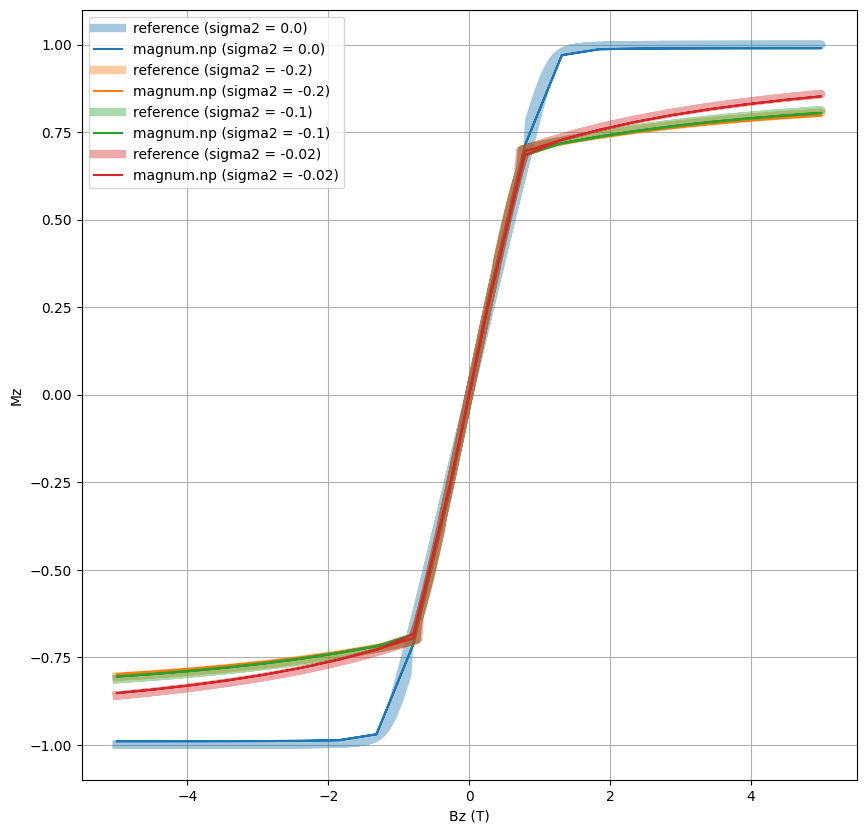

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(figsize=(10, 10))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, sigma in enumerate(np.array([0, -0.1, -0.05, -0.01])):
    ref_Bz = np.load(f"ref/oommf_hysteresis_Bz_sigma2_{sigma}.npy")/1000
    ref_Mz = np.load(f"ref/oommf_hysteresis_mz_sigma2_{sigma}.npy")

    data = np.loadtxt(f"data/m_sigma2_{sigma*2}.dat")
    B = data[:,3]*4*np.pi*1e-7
    M = data[:,9]/2 + data[:,12]/2

    ax.plot(ref_Bz, ref_Mz, '-', color = cycle[i], linewidth = 6, alpha = 0.4, label = f"reference (sigma2 = {sigma*2})")
    ax.plot(B, M, '-', color = cycle[i], label = f"magnum.np (sigma2 = {sigma * 2})")

ax.set_xlabel("Bz (T)")
ax.set_ylabel("Mz")
ax.legend()
ax.grid()
fig.savefig("data/results.png", dpi=300)